In [1]:
import torch
import numpy as np
import argparse
import matplotlib.pyplot as plt

from pathlib import Path
from data_utils import renderHE_UQ_HVNext
from torch.utils.data import DataLoader
from metrics import per_tile_metrics
from constants import (CLASS_NAMES_ARCTIQUE)

/home/vanessa/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
task = 'semantic'
variation = 'blood_cells'
uq_path = '/home/vanessa/Documents/data/uncertainty_arctique_v1-0-corrected_14/'
data_path = '/home/vanessa/Desktop/synth_unc_models/data/v1-0-variations/variations/'
model_noise = 0
image_noise = '0_00'
uq_method = 'tta'
decomp ='pu'
data_mod =  'ood'

In [3]:
uq_maps_path = Path(uq_path).joinpath("UQ_maps")
metadata_path = Path(uq_path).joinpath("UQ_metadata")
preds_path = Path(uq_path).joinpath("UQ_predictions")
data_path = Path(data_path).joinpath(f'{variation}')

In [4]:
preds_path

PosixPath('/home/vanessa/Documents/data/uncertainty_arctique_v1-0-corrected_14/UQ_predictions')

In [5]:
uq_data_loader = renderHE_UQ_HVNext(
        data_path, 
        'test', 
        OOD=(data_mod == 'ood'), 
        image_noise=image_noise
        )
uq_dataset= DataLoader(uq_data_loader, batch_size=1, shuffle=False, prefetch_factor=4, num_workers=2)
    

In [6]:
preds_inst_type = f"instance_noise_{model_noise}_{variation}_{image_noise}_{uq_method}.npy"
preds_sem_type = f"semantic_noise_{model_noise}_{variation}_{image_noise}_{uq_method}.npy"
preds_file_path_inst = preds_path.joinpath(preds_inst_type)
preds_file_path_sem = preds_path.joinpath(preds_sem_type)
preds_inst, preds_sem = np.load(preds_file_path_inst), np.load(preds_file_path_sem)
preds = np.stack((preds_inst, preds_sem), axis=-1)

pred_regr_type = f"regr_noise_{model_noise}_{variation}_{image_noise}_{uq_method}.npy"
preds_file_path_regr = preds_path.joinpath(pred_regr_type)
preds_regr = np.load(preds_file_path_regr, allow_pickle=True)

In [7]:
nclasses = len(CLASS_NAMES_ARCTIQUE)

pred_ins_list = []
pred_regr_list = {}
for i in range(nclasses):
    pred_regr_list[CLASS_NAMES_ARCTIQUE[i]] = []
            
res = [(pr, rg) for _, (pr, rg) in enumerate(zip(preds, preds_regr))]
    
for pr, rg in res:
    for key in pred_regr_list.keys():
        pred_regr_list[key].append(rg[key])
    pred_ins_list.append(pr)

for key in pred_regr_list.keys():
    pred_regr_list[key] = np.array(pred_regr_list[key])

metadata_type = f"{task}_noise_{model_noise}_{variation}_{image_noise}_{uq_method}_{decomp}_sample_idx.npy"
metadata_file_path = metadata_path.joinpath(metadata_type)
indices = np.load(metadata_file_path)

In [8]:
metadata_type = f"{task}_noise_{model_noise}_{variation}_{image_noise}_{uq_method}_{decomp}_sample_idx.npy"
metadata_file_path = metadata_path.joinpath(metadata_type)
indices = np.load(metadata_file_path)

if (uq_data_loader.sample_names == indices).any():
    print('Uncertainty values, predictions and masks indices match')

Uncertainty values, predictions and masks indices match


In [9]:
gt_list = [label.numpy().squeeze() for _ , label in uq_dataset]

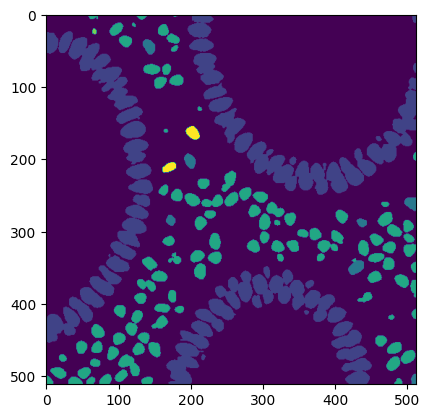

In [20]:
plt.imshow(preds[0][...,1])

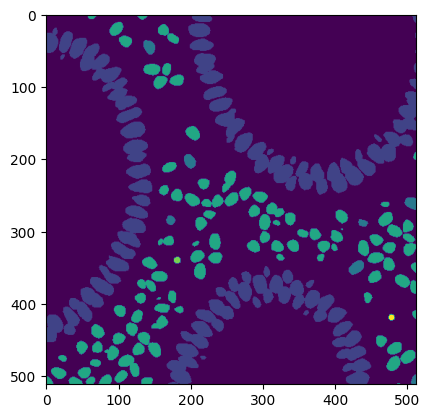

In [19]:
plt.imshow(gt_list[0][...,1])